# Session 4: Running a Model and Post Processing the Results

This session will focus on running a Source model and working with the time series results.

We will do this twice. The first time, we'll mostly accept default options and the second time we will explore various options in more detail.

**Note:** This session uses `ExampleProject/RiverModel2.rsproj`. You are welcome to work with your own model instead, however you will need to change the notebook text at certain points to reflect the names of nodes, links and functions in your model file.

## Overview

- Example - Storage Water Balance
- Two passes - first pass accepts defaults / takes simple options. second pass looks at options
- First Pass
  - Configuring Time Series Recorders
  - Running the model
  - Retrieving results
  - Summarising, Plotting, Analysing and Exporting results
- Second pass / details
  - Configuring time series recorders
    - Individual enable/disable
    - Bulk enable / disable
    - How to work out the ‘keys'
  - Running the model
    - Specifying time periods
    - Specifying input set
    - Other options
    - Other ‘Running Configurations'

## Simple Water Balance Model

The following model is adapted from the introductory tutorials provided by eWater.

![Simple water balance model](Images/Tutorials/RiverModel.PNG)

## Startup

1. Load the Veneer plugin if you haven't already (see instructions in [0Setup_and_Hello_World.ipynb](0Setup_and_Hello_World.ipynb))
2. Start Source
3. Open `ExampleProject/RiverModel2.rsproj`
4. Open the first and only scenario - `Water Balance`
5. Start the Web Server Monitoring window (under the Tools menu) and ensure Veneer is running

## Pass 1

### Import the veneer-py package and initialise the client

Every notebook you create for veneer-py will have an `import` statement to load the veneer package, and a line to initialise a client.

**Notes:**

1. You'll typically have other `import` statements (eg `import pandas as pd`) and other initialisation. I usually group these initial statements together at the top of the notebook, but there is no need to do so in Python. I break with my usual habit for this tutorial, in order to introduce each import as it is required.
2. When initialising the Veneer client, it will default to port number 9876, however I have explictly used `port=9876` below as a reminder of where you may need to change things if the Veneer you are connecting to is running on a different port. This could be the case if you are running more than one copy of Veneer.



In [1]:
import veneer
v = veneer.Veneer(port=9876)

### Configuring recorders

When you trigger a scenario run from Veneer, Source will run just as if you hit the Run button in the toolbar. This includes all run settings (eg start, end date), what 'mode' is used (eg normal run, calibration run, river operations) and with whichever output recorders are enabled.

All of these options can be configured from Python, but by far the most common thing to configure are output recorders.

Outputs are configured using `v.configure_recording()`, which is used for both enabling and disabling recorders

In [2]:
help(v.configure_recording)

Help on method configure_recording in module veneer.general:

configure_recording(enable=[], disable=[]) method of veneer.general.Veneer instance
    Enabled and disable time series recording in the Source model.
    
    enable: List of time series selectors to enable,
    
    disable: List of time series selectors to disable
    
    Note: Each time series selector is a python dictionary object with up to three keys:
      * NetworkElement
      * RecordingElement
      * RecordingVariable
    
    These are used to match time series available from the Source model. A given selector may match
    multiple time series. For example, a selector of {'RecordingVariable':'Downstream Flow Volume'} 
    will match Downstream Flow Volume from all nodes and links.
    
    Any empty dictionary {} will match ALL time series in the model.
    
    So, for example, you could disable ALL recording in the model with
    
    v = Veneer()
    v.configure_recording(disable=[{}])
    
    Note, the t

Configure recording enables very fine grained control as well as very broadscale actions - similar to the project explorer in the user interface.

For example, you can enable `Downstream Flow Volume` at the `Lake Release` minimum flow node with:

```python
v.configure_recording([{'Network Element':'Lake Release', 'RecordingVariable':'Downstream Flow Volume'}])
```

Alternatively, you can disable ALL recording in the model, with

```python
v.configure_recording(disable=[{}])
```

The `enable` and `disable` parameters work in the same way - they both accept a Python list (the `[]` syntax) , where each item in that list contains criteria for matching available output recorders. The criteria are provided in Python dictionaries (the `{}` syntax) - key-value lookup objects where, in this case, the keys can take the values `NetworkElement`, `RecordingElement` and `RecordingVariable`.

Any key that's missing will simply match *all* corresponding elements. For example, ommitting `NetworkElement` will match corresponding output records in all nodes, links and catchments. This is why an empty dictionary - `{}` - matches **all** output recorders.

**Note:** - There is currently a bug whereby the disabling all recorders with an empty dictionary doesn't disable everything - a few odd outputs are left on...

When constructing enable and disable commands, the keys should be used (or omitted) as follows :

* `NetworkElement`: The name of the node,link or catchment of interest - omit to target every network element
* `RecordingVariable`: The specific variable of inerest (eg `Downstream Flow Volume`, or `Water Surface Elevation`) - omit to target every applicable variable
* `RecordingElement`: The 'grouping' of variables, such as 'Demand Model'

Determining `NetworkElement` is straightforward, but the others aren't always clear. Working out values for `RecordingVariable` and `RecordingElement` is covered later in this session.


Lets ensure that we have `Downstream Flow Volume` recorded

In [3]:
v.configure_recording([{'RecordingVariable':'Downstream Flow Volume'}])

As an example, lets disable recording at the inflows and confluences and enable every recorder on the water user

In [4]:
v.configure_recording(enable=[{'NetworkElement':'Crop Fields'}],
                      disable=[{'NetworkElement':'Crab Creek'},{'NetworkElement':'Fish Creek'},
                               {'NetworkElement':'Shell Creek'},{'NetworkElement':'Fish Creek Confluence'},
                               {'NetworkElement':'Shell Creek Confluence'}])

### Running the model

Running the model, with current settings is a matter of calling `v.run_model()`

This will trigger a run, in the same way as pressing the Run button on the toolbar. If the run is successful, the `run_model` function will return a HTTP success code and a URL pointing to the results of the run, such as:

```
(302, 'runs/2')
```

**Note:** HTTP 302 is a redirect code - used for sending your browser to a new URL when the information you wanted has moved. The key thing here is `runs/2` (in this case, there was already simulation results set in memory).

In [5]:
v.run_model()

(302, 'runs/1')

If you have a large model and a lot of outputs recorded, the results can consume a lot of system resources. It can be useful to drop (forget) earlier runs. You can drop all existing runs before a simulation with

```python
v.drop_all_runs()
```

**Note:** After dropping runs, you won't be able to retrieve those results from Source - but any results you've already got in the Python session will remain.

In [6]:
v.drop_all_runs()

In [7]:
v.run_model()

(302, 'runs/1')

### Retrieving results

There is a two step process for retrieving results from Veneer:

1. Retrieve an index of all results from the run - using `v.retrieve_run(id)`, then
2. Retrieve one or more time series using `v.retrieve_multiple_time_series`

You can skip step 1 - `retrieve_multiple_time_series` will do it implicitly - but if you are going to make numerous calls to retrieve time series its more efficient to call `v.retrieve_run` yourself, save the results and pass it in to `v.retrieve_multiple_time_series`.

**Note:** If you know you want the results of the most recent model run, you can omit any reference to the run ID and use the default - the string `'latest'`.

In [8]:
help(v.retrieve_run)

Help on method retrieve_run in module veneer.general:

retrieve_run(run='latest') method of veneer.general.Veneer instance
    Retrieve a results summary for a particular run.
    
    This will include references to all of the time series results available for the run.
    
    run: Run to retrieve. Either 'latest' (default) or an integer run number from 1



In [9]:
results_index = v.retrieve_run()  # This will retrieve the latest run

The `results_index` variable is not particularly user friendly - but it does include information about the run that can come in handy.

In [10]:
results_index

{'DateRun': '10/28/2016 13:49:02',
 'Name': 'Default Input Set (1)',
 'Number': 1,
 'Results': [{'RecordingVariable': 'Flow', 'RecordingElement': 'Upstream Flow', 'TimeSeriesUrl': '/runs/1/location/Default Link 1/element/Upstream Flow/variable/Flow', 'TimeSeriesName': 'Straight-Through Routing: Default Link #1: Upstream Flow', 'NetworkElement': 'Default Link #1', 'RunNumber': 1}, {'RecordingVariable': 'Flow', 'RecordingElement': 'Catchment Inflow', 'TimeSeriesUrl': '/runs/1/location/Default Link 1/element/Catchment Inflow/variable/Flow', 'TimeSeriesName': 'Straight-Through Routing: Default Link #1: Catchment Inflow', 'NetworkElement': 'Default Link #1', 'RunNumber': 1}, {'RecordingVariable': 'Flow', 'RecordingElement': 'Downstream Flow', 'TimeSeriesUrl': '/runs/1/location/Default Link 1/element/Downstream Flow/variable/Flow', 'TimeSeriesName': 'Straight-Through Routing: Default Link #1: Downstream Flow', 'NetworkElement': 'Default Link #1', 'RunNumber': 1}, {'RecordingVariable': 'Stora

One way to get more insight from the `results_index` is to look at the `'Results'` key as a pandas Data Frame

In [11]:
results_index['Results'].as_dataframe()

,NetworkElement,RecordingElement,RecordingVariable,RunNumber,TimeSeriesName,TimeSeriesUrl
0,Default Link #1,Upstream Flow,Flow,1,Straight-Through Routing: Default Link #1: Ups...,/runs/1/location/Default Link 1/element/Upstre...
1,Default Link #1,Catchment Inflow,Flow,1,Straight-Through Routing: Default Link #1: Cat...,/runs/1/location/Default Link 1/element/Catchm...
2,Default Link #1,Downstream Flow,Flow,1,Straight-Through Routing: Default Link #1: Dow...,/runs/1/location/Default Link 1/element/Downst...
3,Default Link #1,Storage Volume,Storage Volume,1,Straight-Through Routing: Default Link #1: Sto...,/runs/1/location/Default Link 1/element/Storag...
4,Default Link #1,Link Travel Time,Link Travel Time,1,Straight-Through Routing: Default Link #1: Lin...,/runs/1/location/Default Link 1/element/Link T...
5,Default Link #1,Groundwater Flux,Groundwater Flux,1,Straight-Through Routing: Default Link #1: Gro...,/runs/1/location/Default Link 1/element/Ground...
6,Default Link #1,Water Surface Elevation,Water Surface Elevation,1,Straight-Through Routing: Default Link #1: Wat...,/runs/1/location/Default Link 1/element/Water ...
7,Default Link #1,Water Surface Area,Water Surface Area,1,Straight-Through Routing: Default Link #1: Wat...,/runs/1/location/Default Link 1/element/Water ...
8,Default Link #1,Lateral Inflow Volume,Lateral Inflow Volume,1,Straight-Through Routing: Default Link #1: Lat...,/runs/1/location/Default Link 1/element/Latera...
9,Default Link #1,Divisions,Upstream Flow,1,TotalInflow,/runs/1/location/Default Link 1/element/Divisi...


We can now use `results_index` as the basis for retrieving time series.

`v.retrieve_multiple_time_series`, is the main function for retrieving time series results.

The retrieved time series are returned as columns of a pandas Data Frame.

You provide up to four pieces of information to `v.retrieve_multiple_time_series`:

1. The run of interest - either by passing in a run number (which defaults to `'latest'`) or by passing a run index using `run_data=`
2. Criteria for matching time series - which work in much the same way as the criteria for `v.configure_recording`
3. The timestep that you're interested in - defaults to `'daily'`, but if you need `'monthly'` or `'annual'`, then your scripts can be a bit simpler by getting the conversion done in Source, rather than Python
4. A function for naming the columns of the data frame based on the nature of the time series - useful for having simple, but unique column names when retrieving multiple time series.

These options are further described in the help text for the function:

In [12]:
help(v.retrieve_multiple_time_series)

Help on method retrieve_multiple_time_series in module veneer.general:

retrieve_multiple_time_series(run='latest', run_data=None, criteria={}, timestep='daily', name_fn=<function name_element_variable at 0x00000000051BB6A8>) method of veneer.general.Veneer instance
    Retrieve multiple time series from a run according to some criteria.
    
    Return all time series in a single Pandas DataFrame with date time index.
    
    you can an index of run results via run_data. If you don't the method will first retrieve an
    index based on the value of the run parameter (default='latest')
    
    criteria should be regexps for the fields in a Veneer time series record:
      * NetworkElement
      * RecordingElement
      * RecordingVariable
      * TimeSeriesName
      * TimeSeriesUrl
    
    These criteria are used to identify which time series to retrieve.
    
    timestep should be one of 'daily' (default), 'monthly', 'annual'
    
    All retrieved time series are returned in a s

Lets start by retrieving all the time series associated with the water user (`'Crop Fields'`)

In [13]:
crop_node_ts = v.retrieve_multiple_time_series(run_data=results_index,
                                               criteria={'NetworkElement':'Crop Fields'})

The data is now stored in `crop_node_ts` as a pandas Data Frame.

It is useful to eyeball the data - to make sure you know what you've got. The Jupyter notebook has good support for looking at data frames.

Here, we will 'slice' the rows of the table to look at an adhoc subset of the data - in this case, every 100 rows

In [14]:
crop_node_ts[::100]

,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Requiremements,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Total Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Return Flow Supplied,Crop Fields:Demand & Storage Interface@Storage@Total Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Water Extracted,...,Crop Fields:Downstream Return Flow,Crop Fields:Id,Crop Fields:Mass Balance,Crop Fields:Planned Extraction,Crop Fields:Storage Volume,Crop Fields:Total Inflow Volume,Crop Fields:Total Outflow Volume,Crop Fields:Upstream Flow,Crop Fields:Upstream Flow Volume,Crop Fields:Volume Ordered
1998-01-11,0,0,44275.0,0.0,0.0,0,0,0,0,0,...,0,94,0,44275.0,0,0,0,0,0,44275.0
1998-04-21,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0
1998-07-30,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0
1998-11-07,0,0,9300.0,9300.0,9300.0,0,0,0,0,0,...,0,94,0,9300.0,0,0,0,0,0,9300.0
1999-02-15,0,0,47520.0,47520.0,47520.0,0,0,0,0,0,...,0,94,0,47520.0,0,0,0,0,0,47520.0
1999-05-26,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0
1999-09-03,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0
1999-12-12,0,0,31625.0,31625.0,31625.0,0,0,0,0,0,...,0,94,0,31625.0,0,0,0,0,0,31625.0
2000-03-21,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0
2000-06-29,0,0,0.0,0.0,0.0,0,0,0,0,0,...,0,94,0,0.0,0,0,0,0,0,0.0


The slice operator `[::]` is standard Python and works with normal Python lists as well as numpy arrays and pandas DataFrames and Series'.

The general form is:

`  [from:to:step]`

Where:

* `from` is the index of the first element to take
* `to` is the index of the element to stop at (non-inclusive)
* `step` allows you to take every n-th element

All are optional, so

`crop_node_ts` is equivalent to `crop_node_ts[:]` and `crop_node_ts[::]`

`crop_node_ts[::100]` is saying, 'from *the start*, to *the end*, take *every 100th element*'

`from` and `to` can be either 0 based indexes, from the start of the list/DataFrame/etc (ie where 0 is the first element), **OR** they can be -1 based, from the end, where -1 is the last element, -2 is the second last element, etc.

Negative values can also be used for the step, indicating that the slice works from the end of the list/dataframe/etc. So

`crop_node_ts[::-2]` takes every second element, working from the end back to the start!


### Manipulating the data

Lets say we want to compute a daily shortfall time series from these results. Essentially we want

```
Water Required - Water Supplied
```

We can do this directly with the columns of the Data Frame

In [15]:
shortfall = crop_node_ts['Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements'] - \
            crop_node_ts['Crop Fields:Demand & Storage Interface@Demand Model@Regulated Water Supplied']

**Notes:**


1. That's could have been a LONG line. Because whitespace is significant in Python, you sometimes need the line continuation character (**`\`**) to tell the language that you want an expression to continue onto the next line
2. Here, we index the DataFrame by the column names - which are rather long. Thankfully, in the notebook you can use `<tab>` completion to fill in long strings like this. Try the following in an empty code cell:
```python
crop_node_ts['Cr<press-tab>
```
The notebook should pop up a menu of available columns
3. Those long column names used the default naming convention for `v.retrieve_multiple_time_series`. We can **(and should)** override this. We'll look at the options later in this session.

At any rate, we should now have a shortfall time series. Lets plot it.

In order to enable plotting in the notebook, we need to specify where we want the plots to appear. For now, we'll plot them inline (see [3_Python_Data_Analysis.ipynb](3_Python_Data_Analysis.ipynb) for more options).

In [16]:
%matplotlib inline

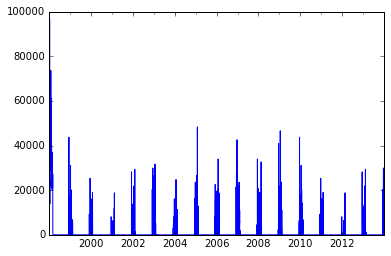

In [17]:
shortfall.plot()

pandas DataFrames have good support for many analyses that you're likely to want to perform.

Lets look at how many days the demand is shortfalled, and by how much...

First, we'll subset out the data where `shortfall>0`

In [18]:
shortfall_days = shortfall[shortfall>0]

Now, we can compute the % of days where a shortfall occurs, and the average of these shortfalls:

In [19]:
pc_shortfall_days = (100.0 * len(shortfall_days) / len(shortfall))
pc_shortfall_days

6.633527596846075

In [20]:
avg_shortfall = shortfall_days.mean()
avg_shortfall

14616.976744186046

### What about units?

The last answer isn't that helpful. We know its a unit of flow, but specifically what? Has it listened to our unit preferences in Source? Is it in SI? Is it an average daily value or an average rate (eg m^3/s)?

In short:

* Veneer returns the units with the time series
* Veneer always returns the units used internally by Source - which isn't always the units you have chosen in unit preferences. These are the units that Source works in and so this approach is consistent across models and users. Given we are in a scripting tool, you can always automate the unit conversion to your preferred units.
* However, pandas DataFrames don't have a great way to represent units. We could include the units in the column name (we'll look at that later).
* The units are available as attributes on the dataframe columns, eg with

```python
crop_node_ts['Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements'].units
```

but these units aren't maintained or propagated when copying or operating on the data

In [21]:
crop_node_ts['Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements'].units

'm³'

### Exporting Data

The pandas DataFrame and Series objects have numerous built in methods for exporting data.

`.to_csv` is likely to be a favourite :)

In [22]:
crop_node_ts.to_csv('crop_results.csv')

In [23]:
!type crop_results.csv

,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Requiremements,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Total Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Return Flow Supplied,Crop Fields:Demand & Storage Interface@Storage@Total Water Supplied,Crop Fields:Demand & Storage Interface@Storage@Water Extracted,Crop Fields:Demand Model@Ordered Water Supplied,Crop Fields:Demand Model@Predicted Order,Crop Fields:Demand Model@Volume Ordered,Crop Fields:Downstream Flow,Crop Fields:Downstream Flow Volume,Crop Fields:Downstream Return Flow,Crop Fields:Id,Crop Fields:Mass Balanc

**Note:** The !type command on the previous line is the `type` command from the Windows Command Prompt. The `!` operator is an IPython prefix for running shell commands.


**This concludes our first pass of running and retrieving results**

## Pass 2 - Indepth

We will now look at running the model again, with more consideration to individual options.

Specifically, we'll

* Look again at configuring recorders including how to perform bulk changes and look at how to establish the criteria
* Run the model again, with control over the time period, input sets and other options
* Look at options for controlling the column names in the DataFrame objects returned by `v.retrieve_multiple_time_series`


### Configuring Recorders

We've already seen that enabling and disabling output recording is based around search criteria using three terms:

* `NetworkElement`
* `RecordingElement`
* `RecordingVariable`

But we've also seen that sometimes, the values of these keys aren't that clear, such as 

```
Demand & Storage Interface@Demand Model@Regulated Requirements
```

Furthermore, we know that we can omit a key, such as `NetworkElement`, in order to match *everything*, but what if you want to match many, but not all cases? For example, what if you want to match all links, or all inflow nodes?


#### Identifying key values

We've seen that

```
Demand & Storage Interface@Demand Model@Regulated Requirements
```

is a key, determined by Source and you need that key to enable/disable that particular recorder.

So how would you go about determining the values to use?

I recommend iteration! One of the benefits of Veneer working with the main Windows application of Source is that you can jump between the two at will. Often, its useful to make a change in the main application and then observe the effect of that change in Python.

So...

In the Source application, visit the Project Explorer and ensure that `Total Water Supplied` is enabled for recording under `Demand & Storage Interface` --> `Demand Model` on the Water User. (It should already be recording from the earlier exercise.

Now, run the model (you can push the Run button in Source or just just execute the next block) - then, retrieve the run results index

In [24]:
v.run_model()

(302, 'runs/2')

In [25]:
results_index = v.retrieve_run()

Once again, it will be useful to get the list of results in a DataFrame

In [26]:
results_df = results_index['Results'].as_dataframe()
results_df

,NetworkElement,RecordingElement,RecordingVariable,RunNumber,TimeSeriesName,TimeSeriesUrl
0,Default Link #1,Upstream Flow,Flow,2,Straight-Through Routing: Default Link #1: Ups...,/runs/2/location/Default Link 1/element/Upstre...
1,Default Link #1,Catchment Inflow,Flow,2,Straight-Through Routing: Default Link #1: Cat...,/runs/2/location/Default Link 1/element/Catchm...
2,Default Link #1,Downstream Flow,Flow,2,Straight-Through Routing: Default Link #1: Dow...,/runs/2/location/Default Link 1/element/Downst...
3,Default Link #1,Storage Volume,Storage Volume,2,Straight-Through Routing: Default Link #1: Sto...,/runs/2/location/Default Link 1/element/Storag...
4,Default Link #1,Link Travel Time,Link Travel Time,2,Straight-Through Routing: Default Link #1: Lin...,/runs/2/location/Default Link 1/element/Link T...
5,Default Link #1,Groundwater Flux,Groundwater Flux,2,Straight-Through Routing: Default Link #1: Gro...,/runs/2/location/Default Link 1/element/Ground...
6,Default Link #1,Water Surface Elevation,Water Surface Elevation,2,Straight-Through Routing: Default Link #1: Wat...,/runs/2/location/Default Link 1/element/Water ...
7,Default Link #1,Water Surface Area,Water Surface Area,2,Straight-Through Routing: Default Link #1: Wat...,/runs/2/location/Default Link 1/element/Water ...
8,Default Link #1,Lateral Inflow Volume,Lateral Inflow Volume,2,Straight-Through Routing: Default Link #1: Lat...,/runs/2/location/Default Link 1/element/Latera...
9,Default Link #1,Divisions,Upstream Flow,2,TotalInflow,/runs/2/location/Default Link 1/element/Divisi...


We can now explore this DataFrame to find the relevant value of `RecordingVariable`

A Python `set` is useful - It's a set, in the mathematical sense of holding unique values

In [27]:
set(results_df.RecordingVariable)

{'0',
 'Actual ET',
 'Allocated Release Volume',
 'Catchment Flux',
 'Ceded Volume',
 'Cluster Solver: Reduced Level',
 'Conveyance Flow Rate',
 'Conveyance Flow Volume',
 'Cumulated Extracted Volume',
 'Data Sources@CrabInflow_csv@Crab_G (ML/day)',
 'Data Sources@Crop Demand_csv@CropDemand (ML)',
 'Data Sources@FishInflow_csv@Fish Creek Flow (ML/day)',
 'Data Sources@LowerGaugeObservedFlow_csv@Lower Gauge Observed (ML/day)',
 'Data Sources@MiddleGaugeObservedFlow_csv@Middle Gauge Observed (ML/day)',
 'Data Sources@ShellInflow_csv@Shell Creek Flow (ML/Day)',
 'Dead Storage Volume',
 'Demand & Storage Interface@Demand Model@Opportunistic Requiremements',
 'Demand & Storage Interface@Demand Model@Opportunistic Water Supplied',
 'Demand & Storage Interface@Demand Model@Regulated Requirements',
 'Demand & Storage Interface@Demand Model@Regulated Water Supplied',
 'Demand & Storage Interface@Demand Model@Total Water Supplied',
 'Demand & Storage Interface@Storage@Opportunistic Water Supplie

And we can see `'Demand & Storage Interface@Demand Model@Total Water Supplied'` in the set - that's what we want.

Lets confirm, but disabling ALL recording at the water user and then enabling just that variable:

In [28]:
v.configure_recording(disable=[{'NetworkElement':'Crop Fields'}],
                      enable=[{'NetworkElement':'Crop Fields','RecordingVariable':'Demand & Storage Interface@Demand Model@Total Water Supplied'}])

Here we've disabled and enabled recorders in the same call. When you do this, **disable will always take place first, regardless of what order you specify disable and enable in the call**.

So, in this case, we disable ALL recorders on the node `Crop Fields` and then re-eanble just the variable of interest.

Now, lets run the model, retrieve the results index and see what we've got

In [29]:
v.run_model()
results_index = v.retrieve_run()
results_df = results_index['Results'].as_dataframe()
set(results_df.RecordingVariable)

{'0',
 'Actual ET',
 'Allocated Release Volume',
 'Catchment Flux',
 'Ceded Volume',
 'Cluster Solver: Reduced Level',
 'Conveyance Flow Rate',
 'Conveyance Flow Volume',
 'Cumulated Extracted Volume',
 'Data Sources@CrabInflow_csv@Crab_G (ML/day)',
 'Data Sources@Crop Demand_csv@CropDemand (ML)',
 'Data Sources@FishInflow_csv@Fish Creek Flow (ML/day)',
 'Data Sources@LowerGaugeObservedFlow_csv@Lower Gauge Observed (ML/day)',
 'Data Sources@MiddleGaugeObservedFlow_csv@Middle Gauge Observed (ML/day)',
 'Data Sources@ShellInflow_csv@Shell Creek Flow (ML/Day)',
 'Dead Storage Volume',
 'Demand & Storage Interface@Demand Model@Total Water Supplied',
 'Diversion Threshold',
 'Downstream Flow',
 'Downstream Flow Volume',
 'Evaporation Volume',
 'External Spill Volume',
 'Extracted Volume',
 'Flow',
 'Flow Based Flux',
 'Full Supply Volume',
 'Functions@End@$Day',
 'Functions@End@$DayOfYear',
 'Functions@End@$DaysInMonth',
 'Functions@End@$Hour',
 'Functions@End@$Month',
 'Functions@End@$Year

**Success!** Total Water Supplied is now the only result available from the demand model.


#### Bulk enable/disable of recorders

Often, getting the recorder configuration right involves a lot of changes. `v.configure_recording` directly supports certain bulk changes by simply omitted keys, such as omitting `RecordingVariable` to record every variable from a particular group on a given node/link/catchment.

However, this isn't always sufficient.

You can achieve other types of bulk configuration using Python to construct lists of fine grained commands.

For example, say you want `Downstream Flow Volume` at every node, but not at links.

You can enable `Downstream Flow Volume` everywhere easily enough

In [30]:
v.configure_recording(enable=[{'RecordingVariable':'Downstream Flow Volume'}])

But to disable recording at just the links, you'll need to identify all the link names.

You can query Veneer for a copy of the network, which will give you all the information you need:

In [31]:
network = v.network()

Now, you can ask for the links:

In [32]:
links = network['features'].find_by_feature_type('link')

A quick look at the first link will show quite a bit of information

In [33]:
links[0]

{'geometry': {'coordinates': [[0, 0], [0, 0]], 'type': 'LineString'},
 'id': '/network/link/0',
 'properties': {'feature_type': 'link',
  'from_node': '/network/nodes/65',
  'name': 'Default Link #1',
  'to_node': '/network/nodes/69'},
 'type': 'Feature'}

We just want the names, so we can ask for that field

In [34]:
link_names = links._all_values('name')
link_names

['Default Link #1',
 'Default Link #2',
 'Default Link #3',
 'Default Link #4',
 'Default Link #5',
 'Default Link #6',
 'Lake Outflow',
 'Default Link #13',
 'Default Link #14',
 'Default Link #15',
 'Default Link #11']

Now, we can use the `link_names` list to construct the commands to disable recording.

Before proceeding, here is a summary of what we have and what we need.

We have - `link_names` - a list of string.

We need - a list of Python dictionaries, each with an instruction to disable some recorder(s) based on criteria. We can only specify one `NetworkElement` per dictionary, so we'll need one dictionary per link.

It'll end up looking something like this:

```python
[
 {'NetworkElement':'Default Link #1'},
 {'NetworkElement':'Default Link #2'},
 ...
 {'NetworkElement':'Default Link #11'}
]
```

But of course it will be very tedious to write that out **AND** the script wouldn't be transferrable to another Source model.

There are various ways to construct the final data structure (list of dictionaries) from what we have (list of strings). The Python [list comprehensions](http://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html) is the most elegant and 'Pythonic' approach:

In [35]:
disable_commands = [{'NetworkElement':link_name,'RecordingVariable':'Downstream Flow Volume'} for link_name in link_names]
disable_commands

[{'NetworkElement': 'Default Link #1',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #2',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #3',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #4',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #5',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #6',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Lake Outflow',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #13',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #14',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #15',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #11',
  'RecordingVariable': 'Downstream Flow Volume'}]

_**Aside:** Now... That's not the simplest list comprehension to start with. Here are a few simple examples_

In [36]:
# double every number in a list
[i*2 for i in [1,3,45,6]]

[2, 6, 90, 12]

In [37]:
# Convert all the link names to upper case (not that we'd want to do that - Source is definitely case sensitive!)
[s.upper() for s in link_names]

['DEFAULT LINK #1',
 'DEFAULT LINK #2',
 'DEFAULT LINK #3',
 'DEFAULT LINK #4',
 'DEFAULT LINK #5',
 'DEFAULT LINK #6',
 'LAKE OUTFLOW',
 'DEFAULT LINK #13',
 'DEFAULT LINK #14',
 'DEFAULT LINK #15',
 'DEFAULT LINK #11']

And, just for fun (and to showcase what you can do with 'slicing')

In [38]:
# Reverse all the link names!
# Note how its reversed the original link names, not the upper case versions.
# The previous list comprehension hasn't modified the original values in the list
[s[::-1] for s in link_names]

['1# kniL tluafeD',
 '2# kniL tluafeD',
 '3# kniL tluafeD',
 '4# kniL tluafeD',
 '5# kniL tluafeD',
 '6# kniL tluafeD',
 'wolftuO ekaL',
 '31# kniL tluafeD',
 '41# kniL tluafeD',
 '51# kniL tluafeD',
 '11# kniL tluafeD']

Now... back to it...

We have our list of dictionaries:


In [39]:
disable_commands

[{'NetworkElement': 'Default Link #1',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #2',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #3',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #4',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #5',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #6',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Lake Outflow',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #13',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #14',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #15',
  'RecordingVariable': 'Downstream Flow Volume'},
 {'NetworkElement': 'Default Link #11',
  'RecordingVariable': 'Downstream Flow Volume'}]

It's just a matter of passing that to `v.configure_recording`

In [40]:
v.configure_recording(disable=disable_commands)

Lets run the model, and retrieve `Downstream Flow Volume` to make sure that we don't have any columns for the links

In [41]:
v.run_model()
flow_ts = v.retrieve_multiple_time_series(criteria={'RecordingVariable':'Downstream Flow Volume'})


In [42]:
flow_ts.columns

Index(['Crab Creek:Downstream Flow Volume',
       'Crop Fields:Downstream Flow Volume',
       'Evaluation Gauge:Downstream Flow Volume',
       'Fish Creek Confluence:Downstream Flow Volume',
       'Fish Creek:Downstream Flow Volume',
       'Lake Release:Downstream Flow Volume',
       'Lower Gauge:Downstream Flow Volume',
       'Middle Gauge:Downstream Flow Volume',
       'Recreational Lake:Downstream Flow Volume',
       'Shell Creek Confluence:Downstream Flow Volume',
       'Shell Creek:Downstream Flow Volume',
       'Supply Point 13:Downstream Flow Volume'],
      dtype='object')

Great! Now flow on the links

Now... we've run th model a bunch of times. We can confirm that by asking for an index of all runs

In [43]:
v.retrieve_runs()

[{'RunName': 'Default Input Set (1)', 'RunUrl': '/runs/1'},
 {'RunName': 'Default Input Set (2)', 'RunUrl': '/runs/2'},
 {'RunName': 'Default Input Set (3)', 'RunUrl': '/runs/3'},
 {'RunName': 'Default Input Set (4)', 'RunUrl': '/runs/4'}]

Lets delete these runs - we don't need them!

In [44]:
v.drop_all_runs()

### Runtime options

Up until now, we have run the model with a call to `v.run_model()`, without specifying any options. In this case, the effect is the same as pushing the Run button in Source - all the currently set options are used.

You can also specify numerous options from Python.

This is useful for batch running (eg by changing input sets), but also when a model is built, configured and saved with one set of options, but you need different options in your script. For example, you might want to run over a different time period for calibration or event analysis.

We can find out a bit about the avilable options by asking for help on `run_model`

In [45]:
help(v.run_model)

Help on method run_model in module veneer.general:

run_model(params={}, start=None, end=None, async=False, **kwargs) method of veneer.general.Veneer instance
    Trigger a run of the Source model
    
    params: Python dictionary of parameters to pass to Source. Should match the parameters expected
            of the running configuration. (If you just want to set the start and end date of the simulation,
            use the start and end parameters
    
    start, end: The start and end date of the simulation. Should be provided as Date objects or as text in the dd/mm/yyyy format
    
    async: (default False). If True, the method will return immediately rather than waiting for the simulation to finish.
           Useful for triggering parallel runs. Method will return a connection object that can then be queried to know
           when the run has finished.
    
    kwargs: optional named parameters to be used to update the params dictionary
    
    In the default behaviour (asyn

We'll ignore the `async` option for now - its for parallel computing.

`start` and `end` provide convenient ways to specify the run time period.

All other options are specified via `params` - a Python dictionary. Note the following important part of the help:

```
Should match the parameters expected of the running configuration.
```

In other words, there are different parameters depending on whether you are in Single Analysis mode, River Operations mode, Flow Calibration mode, or some other mode defined by a plugin.

The following parameters are most likely to be useful:

* `SelectedInputSet` - the name of the input set to run with (available in at least Single Analysis mode and River Operations mode, probably more)
* `WarmUpStart`, `Today` and `ForecastLength` - used in River Operations mode to control the simulation dates including the switch from historical to forecast mode

Note, you can pass the params parameter, or pass named parameters at the end of the parameter list

Lets start by restricting the run period for the model

In [46]:
v.run_model(start='01/01/2000',end='31/12/2009')

(302, 'runs/1')

**Notes:**

* We've just passed strings in the dd/mm/yyyy format, but you can also pass Python datetime objects
* **IMPORTANT** when you set the start and end date (and other options), you are changing the configuration within Source. Meaning a subsequent run (either using the Run button or `v.run_model()` without parameters) will use these new settings!

Now, lets try changing the input set...

We can query the input sets with `v.input_sets()`

In [47]:
input_sets = v.input_sets()
input_sets

[{'Configuration': ['Nodes.Supply Point 13.Maximum Extraction Rate = 100000 ML/d'], 'URL': '/inputSets/Unrestricted Take', 'Name': 'Unrestricted Take'}, {'Configuration': [], 'URL': '/inputSets/Default Input Set', 'Name': 'Default Input Set'}]

Lets look at what the `'Unrestricted Take'` input set does. (We can only see the parameter changes - not time series or other effects)

In [48]:
input_sets[1]['Configuration']

[]

Looks like it removes the extraction rate constraint on the supply point.

Lets run the model with that input set

In [49]:
v.run_model(SelectedInputSet='Unrestricted Take')

(302, 'runs/2')

### Retrieving results

When we looked at `v.retrieve_multiple_time_series` earlier in this session, we noted that some of the column names were quite long and not particularly convenient.

We also noted a `name_fn` parameter, but didn't use it.

The `name_fn` parameter expects a function, and it expects that function to accept a result (essentially the metadata about a time series) and to return a string (to be used as the column name).

This is useful because in different circumstances different column naming conventions make sense.

For example, if you are retrieving the same variable at multiple locations, it probably makes sense to use the location as the column name.

There are a number of suitable functions supplied with veneer-py, which you can choose between, or you can write your own.

**Note:** *`v.retrieve_multiple_time_series` could do a better job of picking this by default (and will in the future!), but I expect that the option will remain!*

Lets start by using the 'name for location' approach when retrieving `Downstream Flow Volume`

In [50]:
flow_ts = v.retrieve_multiple_time_series(criteria={'RecordingVariable':'Downstream Flow Volume'},
                                          name_fn=veneer.name_for_location)
flow_ts[0:10]

,Crab Creek,Crop Fields,Evaluation Gauge,Fish Creek,Fish Creek Confluence,Lake Release,Lower Gauge,Middle Gauge,Recreational Lake,Shell Creek,Shell Creek Confluence,Supply Point 13
2000-01-01,109468.8,0,273024.0,160704.0,270172.8,1380.591827,0.000000,0.0,1380.591827,273024.0,273024.0,0.000000
2000-01-02,107308.8,0,266976.0,157248.0,264556.8,7641.963014,0.000000,0.0,7641.963014,266976.0,266976.0,0.000000
2000-01-03,105235.2,0,531100.8,154656.0,259891.2,17440.287639,0.000000,270172.8,17440.287639,260928.0,531100.8,0.000000
2000-01-04,103248.0,0,519436.8,152064.0,255312.0,30134.715734,0.000000,264556.8,30134.715734,254880.0,519436.8,0.000000
2000-01-05,101260.8,0,509587.2,148608.0,249868.8,42242.989738,0.000000,259891.2,42242.989738,249696.0,509587.2,0.000000
2000-01-06,99446.4,0,498960.0,146016.0,245462.4,53792.585344,0.000000,255312.0,53792.585344,243648.0,498960.0,0.000000
2000-01-07,97632.0,0,488332.8,143424.0,241056.0,64787.790301,9587.790301,249868.8,64787.790301,238464.0,488332.8,9587.790301
2000-01-08,95817.6,0,479606.4,140832.0,236649.6,75266.322636,23516.322636,245462.4,75266.322636,234144.0,479606.4,23516.322636
2000-01-09,94089.6,0,470016.0,138240.0,232329.6,85253.911986,43278.911986,241056.0,85253.911986,228960.0,470016.0,43278.911986
2000-01-10,92448.0,0,461289.6,136512.0,228960.0,94762.922414,60262.922414,236649.6,94762.922414,224640.0,461289.6,60262.922414


There are a number of naming functions under the veneer namespace, all starting with `.name_`.

You can explore the list using `<tab>` completion.

```python
veneer.name_<press tab>
```

You can also create your own function.

We previously had a DataFrame with columns such as

```
'Demand & Storage Interface@Demand Model@Total Water Supplied'
```

If we are getting multiple variables from the one node, it would be nice to just have the last part of this string as the column name - ie `Total Water Supplied`.

Mind you, there were multiple variables that ended with `Total Variable Supplied` - and we need column names to be unique. To recap, we had:

```
 'Demand & Storage Interface@Demand Model@Opportunistic Requiremements',
 'Demand & Storage Interface@Demand Model@Opportunistic Water Supplied',
 'Demand & Storage Interface@Demand Model@Regulated Requirements',
 'Demand & Storage Interface@Demand Model@Regulated Water Supplied',
 'Demand & Storage Interface@Demand Model@Total Water Supplied',
 'Demand & Storage Interface@Storage@Opportunistic Water Supplied',
 'Demand & Storage Interface@Storage@Regulated Water Supplied',
 'Demand & Storage Interface@Storage@Return Flow Supplied',
 'Demand & Storage Interface@Storage@Total Water Supplied',
 'Demand & Storage Interface@Storage@Water Extracted',
```

For now, lets assume that we just want the data related to the Demand Model, not the on farm storage.

So, we need to:

1. Ensure we only get the Demand Model time series, and
2. Name the columns for the last part of the name

First, lets re-enable the demand model recording and re-run the model

In [51]:
v.configure_recording(enable=[{'Network Element':'Crop Fields'}])
v.run_model()

(302, 'runs/3')

Out naming function will take some metadata about the results. This metadata will be a Python dictionary, with keys we've seen before - 'NetworkElement', 'RecordingVariable' etc, along with a few others, notably 'Units'

It just needs to return a string, which it will construct from the metadata

In [52]:
def custom_naming(metadata):
    variable_name = metadata['RecordingVariable']
    if variable_name=='Flow': variable_name = metadata['RecordingElement']
    variable_bit = variable_name.split('@')[-1]
    return variable_bit

That's more complex than things we've seen to date.

Here is a rundown:

1. Define the function and its parameter:
```python
def custom_naming(metadata):
```
2. Find the field we want
```python
    variable_name = metadata['RecordingVariable']
```
3. Lots of things are called `Flow` in Source - `RecordingElement` comes in handy here - it usually has `'Downstream Flow'` or `'Upstream Flow'` or similar
```python
    if variable_name=='Flow': variable_name = metadata['RecordingElement']
```
4. Split the string based on the `'@'` as a delimiter and take the last element of the list of sub-strings
```python
    variable_bit = variable_name.split('@')[-1]
```
5. Return that to the caller
```python
    return variable_bit
```

We can construct a bit of test metadata to confirm this function is doing what we expect

In [53]:
test_metadata = {'RecordingVariable':'Demand & Storage Interface@Demand Model@Total Water Supplied'}
custom_naming(test_metadata)

'Total Water Supplied'

OK, our function is naming the way we want, but if we use it to retrieve all time series from the `Crop Fields` node, we'll have errors due to duplicate column names:

In [54]:
try:
    time_series = v.retrieve_multiple_time_series(criteria={'NetworkElement':'Crop Fields'},name_fn=custom_naming)
except Exception as e:
    print("Had an error")
    print(e)

**Note:** The `try` and `except` block is an example of handling exceptions.

In this case, its because I want to demonstrate an error, but an error would prevent the notebook from running to completion - unless its caught in an `except` block


So, we have duplicate column names, because we've been retrieving the time series for both the demand model and the storage.

We want to be more specific when retrieving the time series.

Importantly, every item in the `criteria` dictionary passed to `v.retrieve_multiple_time_series` is a regular expression - a text pattern that can match partial strings and the like. The way we've used the `criteria` until now has relied on exact matches, but now we'll ensure that we only retrieve time series that have `@Demand Model@` in the name:




In [55]:
crop_ts = v.retrieve_multiple_time_series(criteria={'NetworkElement':'Crop Fields','RecordingVariable':'.*@Demand Model@.*'},
                                         name_fn=custom_naming)
crop_ts[0:10]

,Opportunistic Requiremements,Opportunistic Water Supplied,Regulated Requirements,Regulated Water Supplied,Total Water Supplied
2000-01-01,0,0,40825.0,1380.591827,1380.591827
2000-01-02,0,0,43700.0,7641.963014,7641.963014
2000-01-03,0,0,40825.0,17440.287639,17440.287639
2000-01-04,0,0,48875.0,30134.715734,30134.715734
2000-01-05,0,0,57500.0,42242.989738,42242.989738
2000-01-06,0,0,66125.0,53792.585344,53792.585344
2000-01-07,0,0,55200.0,55200.000000,55200.000000
2000-01-08,0,0,51750.0,51750.000000,51750.000000
2000-01-09,0,0,41975.0,41975.000000,41975.000000
2000-01-10,0,0,34500.0,34500.000000,34500.000000


The regular expression we used was `.*@Demand Model@.*`.

The `@Demand Model@` bit is the exact match we're looking for.

The `.*` bits at the begin and end are wildcards:

* `.` means - match anything
* `*` means - match 0 or more of the last thing (which, in our case is `.` - anything)

So `.*` means 'match 0 or more characters

## Conclusion

This concludes sesion 4, where we looked at running Source simulations from Python.

In particular, we looked at:

* Configuring the output recorders we wanted to use,
* Running the model with default options and various script specified options
* Retrieving and post processing results including controlling exact what gets retrieved and how it gets labelled.

The next session looks at modifying the Source model and running various types of iterative analyses, involving multiple simulations.